## LSTM Iterator

##### Imports

In [1]:
import _lstm_utils as lstm_utils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import _data_utils as data_utils
from keras.models import Sequential
from keras.layers import Dense, LSTM
from tqdm.notebook import tqdm
# *Note* -> Add a config.py file to the local directory with two variables: HTTP Headers (headers: dict) and FRED API Key (fred_api_key: str)

2024-01-15 20:54:45.091937: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-15 20:54:45.091963: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-15 20:54:45.092936: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-15 20:54:45.097739: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-15 20:54:45.649385: W tensorflow/compiler/tf2

##### Pull S&P Ticker and Weight Data

In [2]:
sp_df = data_utils.get_sp_ticker_list()
sp_df

/home/henrywh/Desktop/PORTFOLIO PROJECTS/LSTM Iterator/lstm-iterative-price-prediction/_data_utils.py:25: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  s_p_df = pd.read_html(str(tables[0]))[0]


,#,Company,Symbol,Price,Chg,% Chg,Weight
0,1,Microsoft Corp,MSFT,388.47,3.84,(1.00%),7.08
1,2,Apple Inc.,AAPL,185.92,0.33,(0.18%),6.78
2,3,Amazon.com Inc,AMZN,154.62,-0.56,(-0.36%),3.48
3,4,Nvidia Corp,NVDA,547.10,-1.12,(-0.20%),3.34
4,5,Alphabet Inc. Class A,GOOGL,142.65,0.57,(0.40%),2.10
...,...,...,...,...,...,...,...
498,499,Ralph Lauren Corporation,RL,138.02,-4.51,(-3.16%),0.01
499,500,V.F. Corporation,VFC,16.21,-0.75,(-4.42%),0.01
500,501,"Mohawk Industries, Inc.",MHK,101.85,-2.61,(-2.50%),0.01
501,502,Fox Corporation Class B,FOX,28.75,0.13,(0.45%),0.01


##### Ticker List

In [3]:
ticker_weights = sp_df[['Symbol','Weight']]
ticker_weights['Weight'] = ticker_weights['Weight']/100

/tmp/ipykernel_562657/1190938767.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_weights['Weight'] = ticker_weights['Weight']/100


##### Iterator Method

In [4]:
def get_lstm_pred(ticker, macro_features, start_date, end_date, train_prop, val_prop, look_back, epochs):
    ## PREPROCESSING
    stock_dict = data_utils.get_stock_prices(ticker, start_date, end_date)
    stock_df = stock_dict[ticker[0]]
    pr_vol_df = pd.DataFrame({'Volume':stock_df['Volume'], 'Price':stock_df['Adj Close']})
    data_df = pd.concat([macro_features, pr_vol_df], axis=1).dropna()
    dates, data_sc = lstm_utils.minmax_scale(data_df) # min mac scale
    # Train/test split
    dates_train, data_train, dates_val, data_val, dates_test, data_test = lstm_utils.tvt_split(dates, data_sc, train_prop=train_prop, val_prop=val_prop)
    # create sliding window sequences
    x_train, y_train = lstm_utils.arr_to_xy(data_train, look_back=look_back)
    x_val, y_val = lstm_utils.arr_to_xy(data_val, look_back=look_back)
    x_test, y_test = lstm_utils.arr_to_xy(data_test, look_back=look_back)
    ## MODEL ARCHITECTURE
    model = Sequential()
    model.add(LSTM(units=256, input_shape=(x_train.shape[1], x_train.shape[2]), activation='tanh')) # Use tanh for GPU acceleration
    model.add(Dense(512))
    model.add(Dense(256))
    model.add(Dense(1))
    model.build()
    model.compile(loss='mean_squared_error', optimizer='adam', metrics = ['mae'])
    ## MODEL TRAINING/PREDICTIONS
    train_pred, val_pred, test_pred = lstm_utils.lstm_model_fit_pred(model, x_train, y_train, x_val, y_val, x_test, epochs, verbose=0)
    ## SHOW MODEL/STRATEGY RESULTS
    backtest_df = lstm_utils.simple_backtest(look_back, dates_test, y_test, test_pred)
    lstm_utils.pred_vis(look_back, dates_train, dates_val, dates_test, y_train, y_val, y_test, 
                  train_pred, val_pred, test_pred, show_train=False, show_val=False, show_test=True, ticker=ticker[0])
    
    return backtest_df

##### Parameters

In [5]:
start_date = '2009-07-01'
end_date = '2023-03-01'
train_prop = 0.8    # Training roportion
val_prop = 0.1     # Validation proportion
look_back = 20      # Days to look back 
epochs = 40         # Epochs for training
num_stocks = 20     # Number of Stocks to Iterate through (chooses num_stocks highest weighted in S&P)

##### Other Macro Features

In [6]:
fred = data_utils.init_fred() # Initialize FRED API
macro = data_utils.get_fred_data(fred, {'VIXCLS': 'VIX', 'DGS3MO': '3 Mo Yield'}, start_date, end_date) # API calls for VIX and 3 Mo. Rate
macro

,VIX,3 Mo Yield
2009-07-01,26.22,0.17
2009-07-02,27.95,0.17
2009-07-03,NaN,NaN
2009-07-06,29.00,0.19
2009-07-07,30.85,0.19
...,...,...
2023-02-23,21.14,4.84
2023-02-24,21.67,4.86
2023-02-27,20.95,4.89
2023-02-28,20.70,4.88


In [7]:
ticker_list = ticker_weights.iloc[:num_stocks]
ticker_list # Stocks that are used in the analysis/strategy

,Symbol,Weight
0,MSFT,0.0708
1,AAPL,0.0678
2,AMZN,0.0348
3,NVDA,0.0334
4,GOOGL,0.0210
5,META,0.0205
6,GOOG,0.0178
7,BRK-B,0.0167
8,TSLA,0.0161
9,LLY,0.0125


##### Iteration Through Tickers

  0%|          | 0/20 [00:00<?, ?it/s]

[*********************100%%**********************]  1 of 1 completed
2024-01-15 20:54:48.830031: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-15 20:54:48.830365: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-15 20:54:48.863750: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/t

11/11 [==============================] - 0s 1ms/step


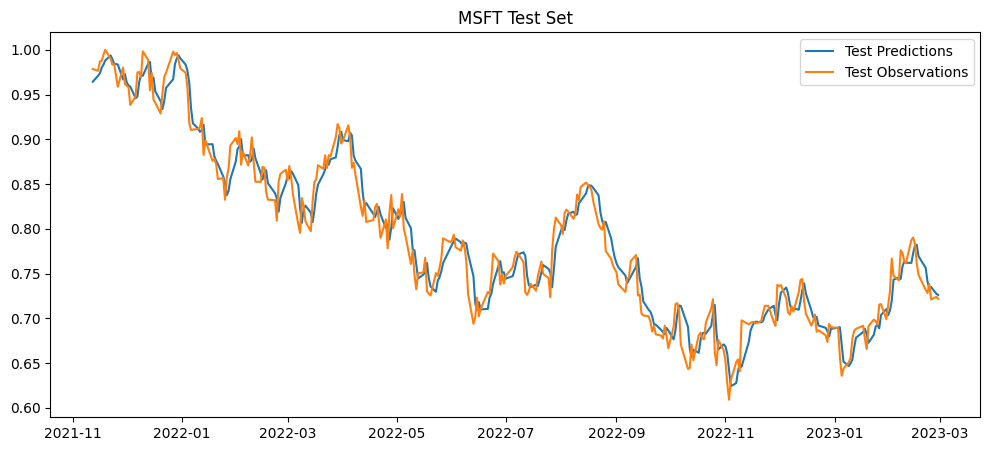

Completed MSFT (1/20 iterations)


[*********************100%%**********************]  1 of 1 completed


11/11 [==============================] - 0s 2ms/step


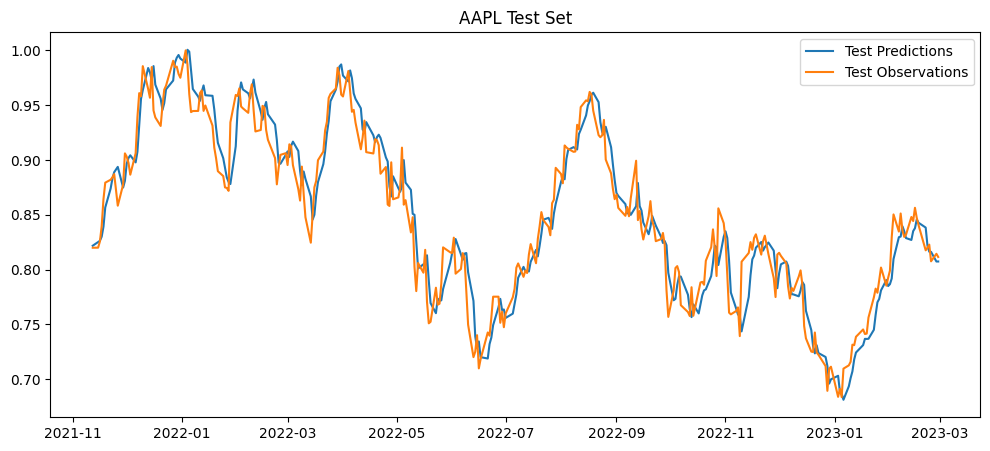

Completed AAPL (2/20 iterations)


[*********************100%%**********************]  1 of 1 completed


11/11 [==============================] - 0s 953us/step


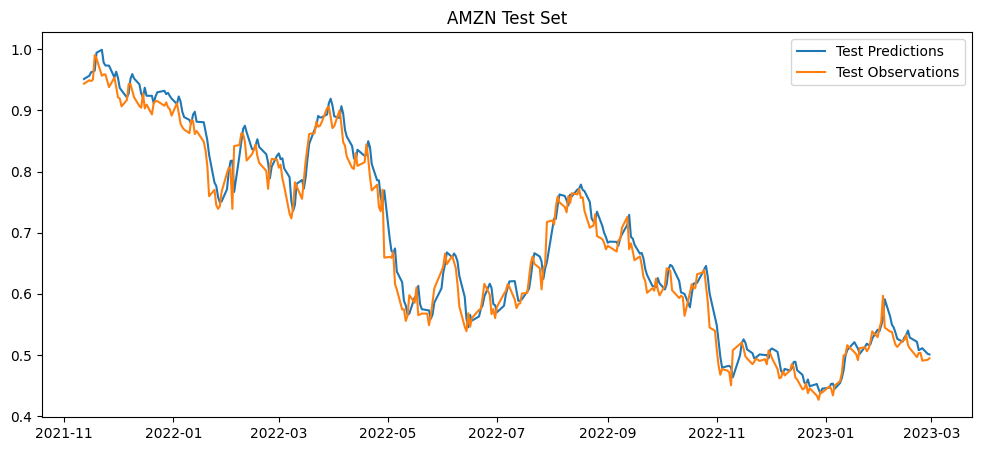

Completed AMZN (3/20 iterations)


[*********************100%%**********************]  1 of 1 completed


11/11 [==============================] - 0s 1ms/step


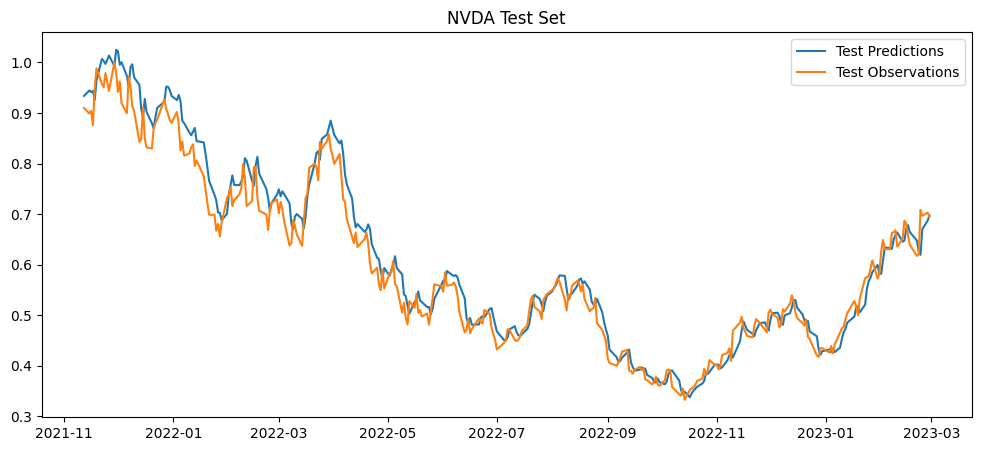

Completed NVDA (4/20 iterations)


[*********************100%%**********************]  1 of 1 completed


11/11 [==============================] - 0s 909us/step


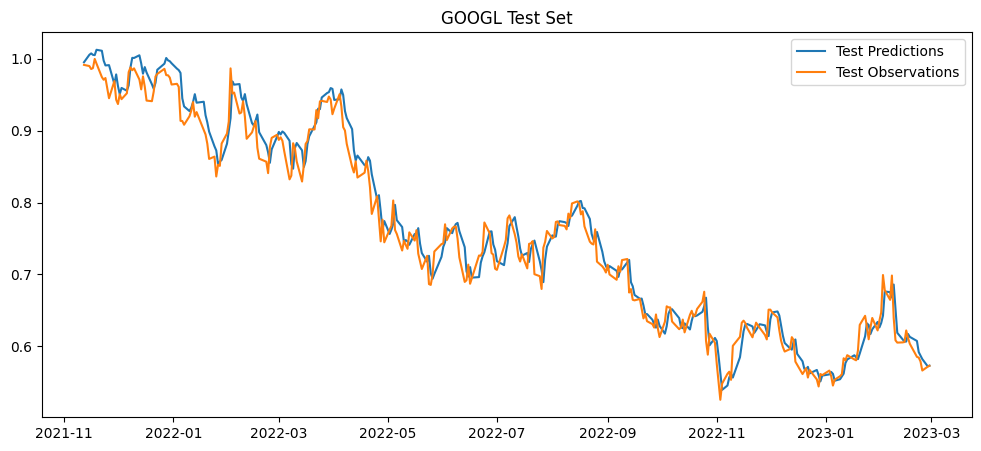

Completed GOOGL (5/20 iterations)


[*********************100%%**********************]  1 of 1 completed


8/8 [==============================] - 0s 994us/step


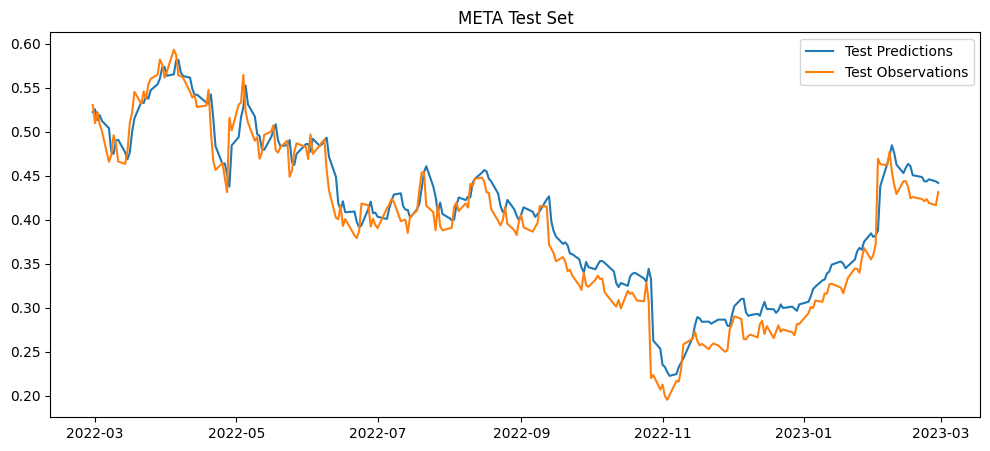

Completed META (6/20 iterations)


[*********************100%%**********************]  1 of 1 completed


11/11 [==============================] - 0s 849us/step


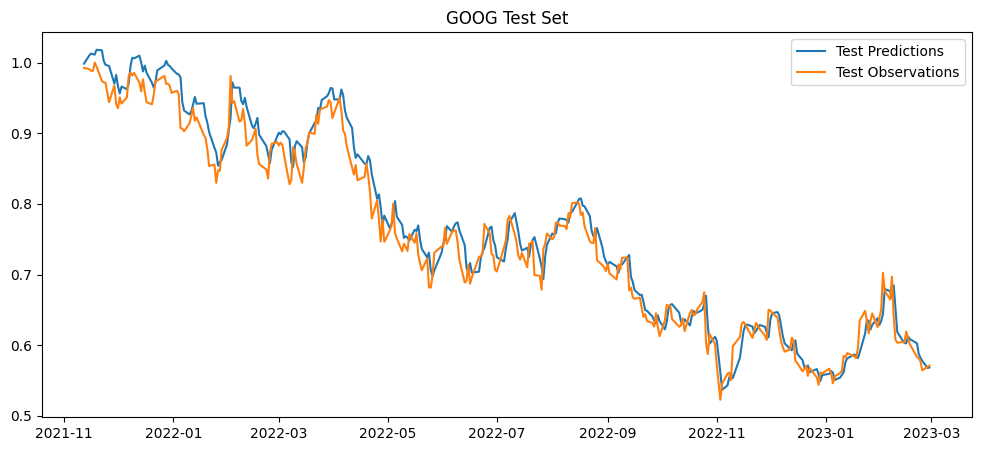

Completed GOOG (7/20 iterations)


[*********************100%%**********************]  1 of 1 completed


11/11 [==============================] - 0s 826us/step


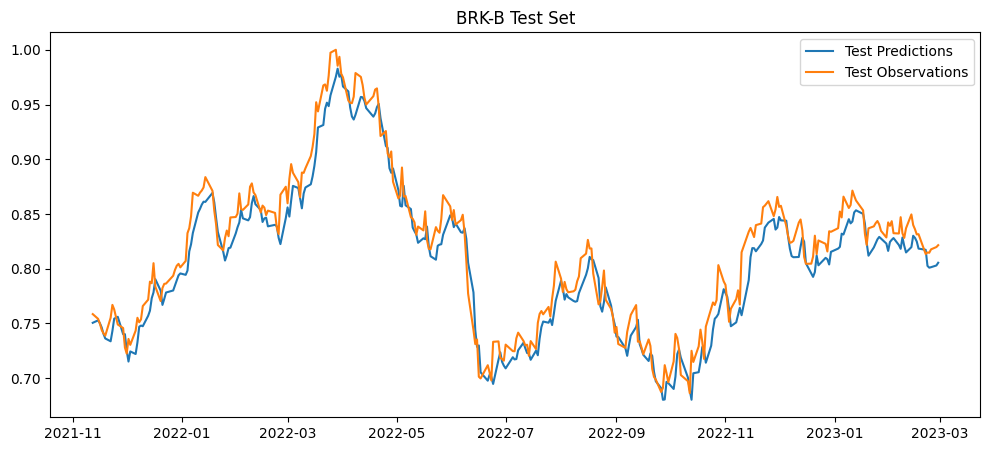

Completed BRK-B (8/20 iterations)


[*********************100%%**********************]  1 of 1 completed


10/10 [==============================] - 0s 925us/step


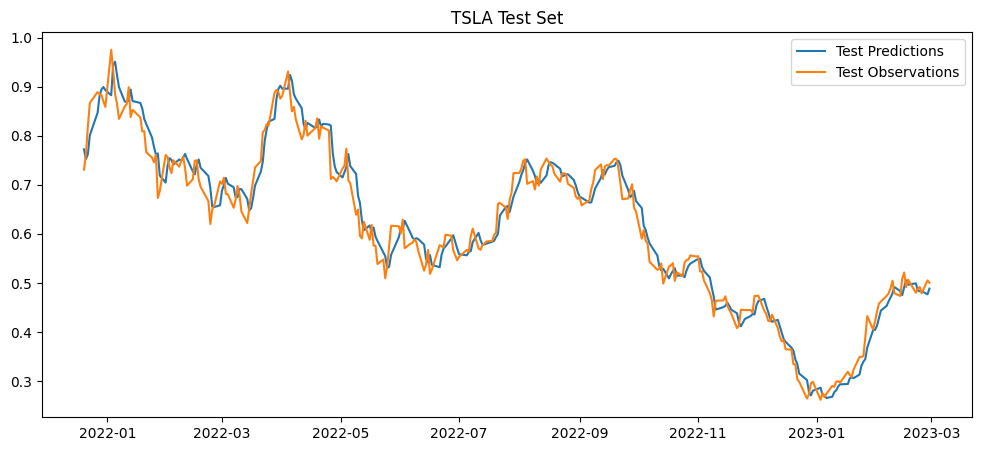

Completed TSLA (9/20 iterations)


[*********************100%%**********************]  1 of 1 completed


11/11 [==============================] - 0s 916us/step


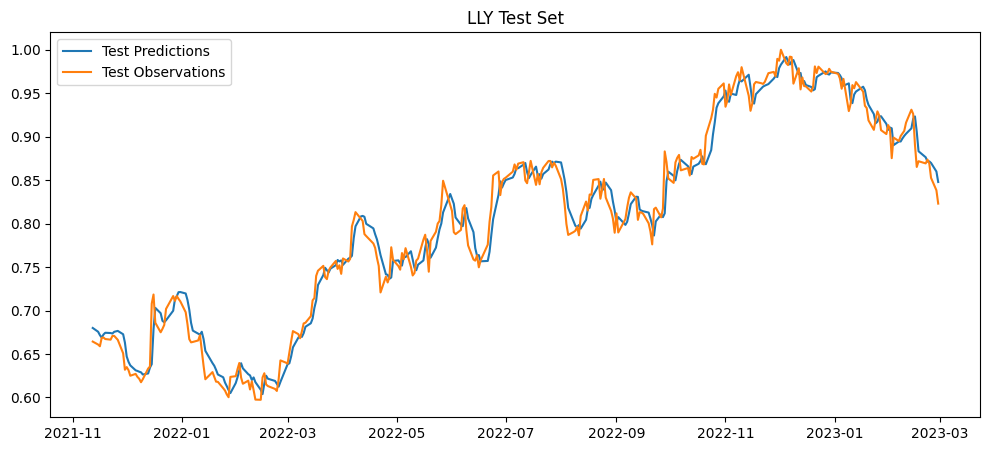

Completed LLY (10/20 iterations)


[*********************100%%**********************]  1 of 1 completed


11/11 [==============================] - 0s 890us/step


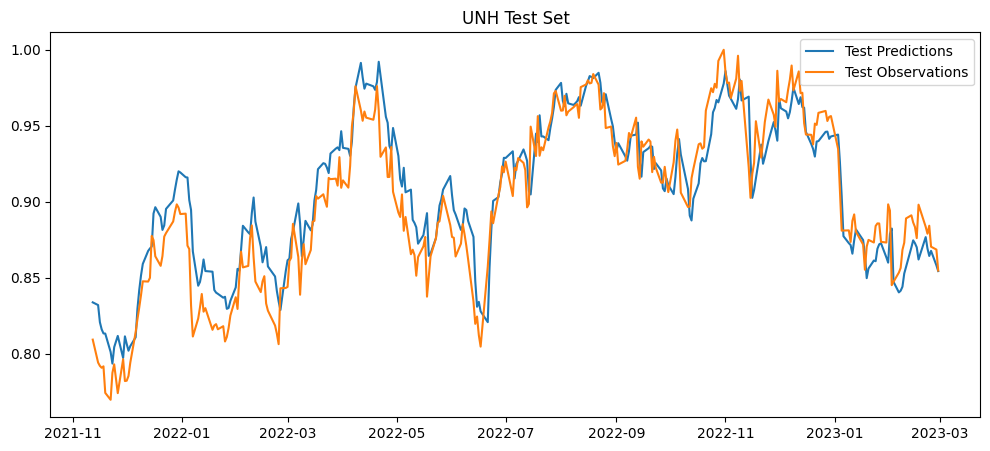

Completed UNH (11/20 iterations)


[*********************100%%**********************]  1 of 1 completed


11/11 [==============================] - 0s 1ms/step


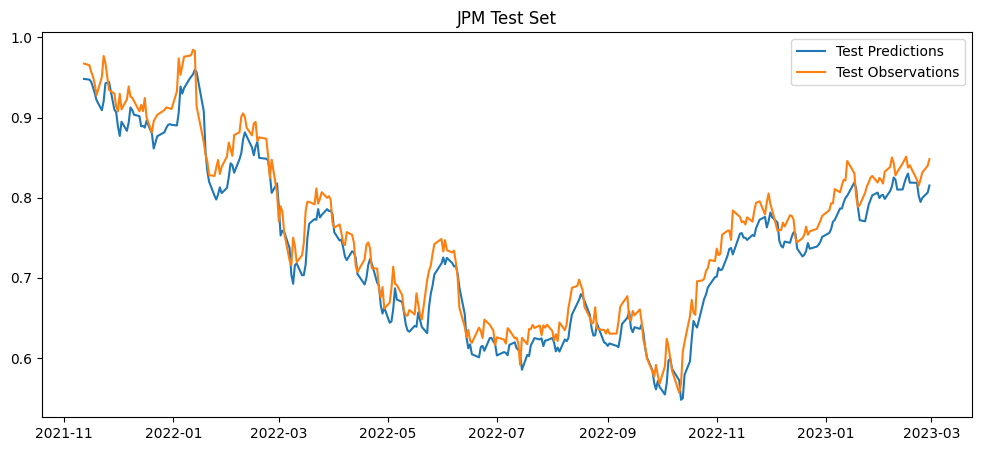

Completed JPM (12/20 iterations)


[*********************100%%**********************]  1 of 1 completed


10/10 [==============================] - 0s 921us/step


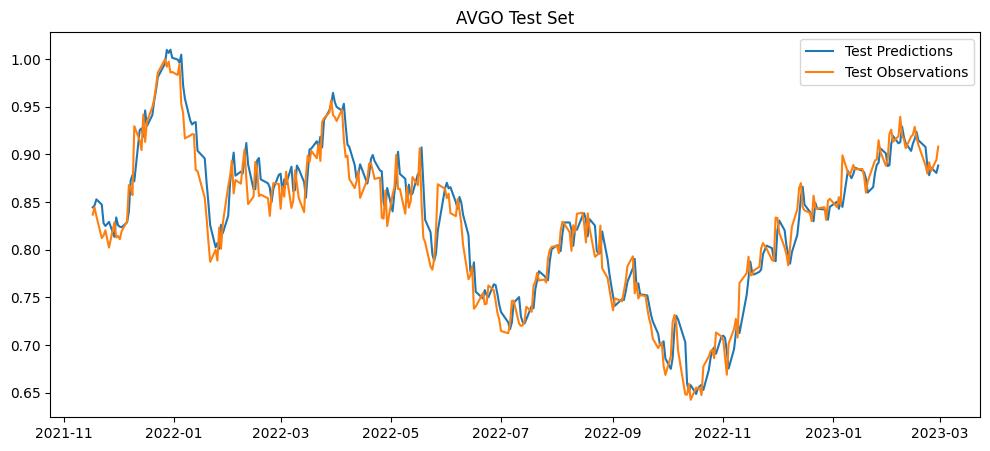

Completed AVGO (13/20 iterations)


[*********************100%%**********************]  1 of 1 completed


11/11 [==============================] - 0s 811us/step


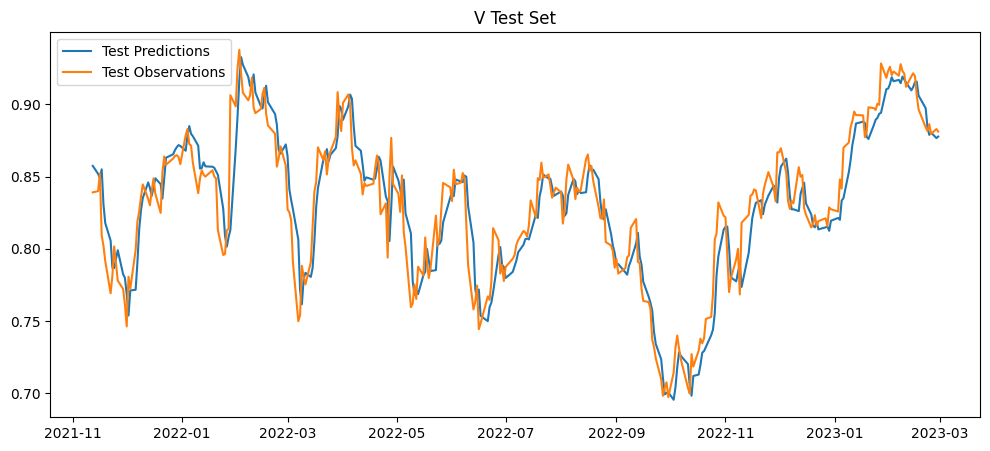

Completed V (14/20 iterations)


[*********************100%%**********************]  1 of 1 completed


11/11 [==============================] - 0s 847us/step


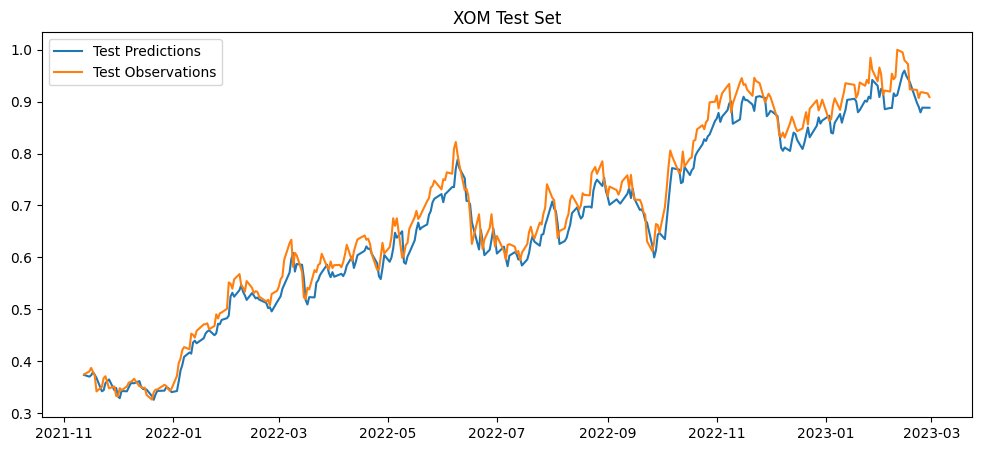

Completed XOM (15/20 iterations)


[*********************100%%**********************]  1 of 1 completed


11/11 [==============================] - 0s 861us/step


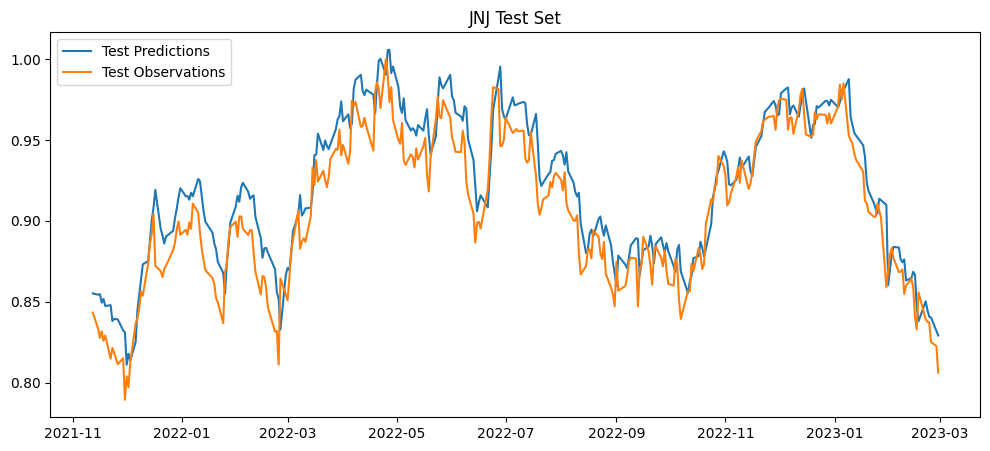

Completed JNJ (16/20 iterations)


[*********************100%%**********************]  1 of 1 completed


11/11 [==============================] - 0s 912us/step


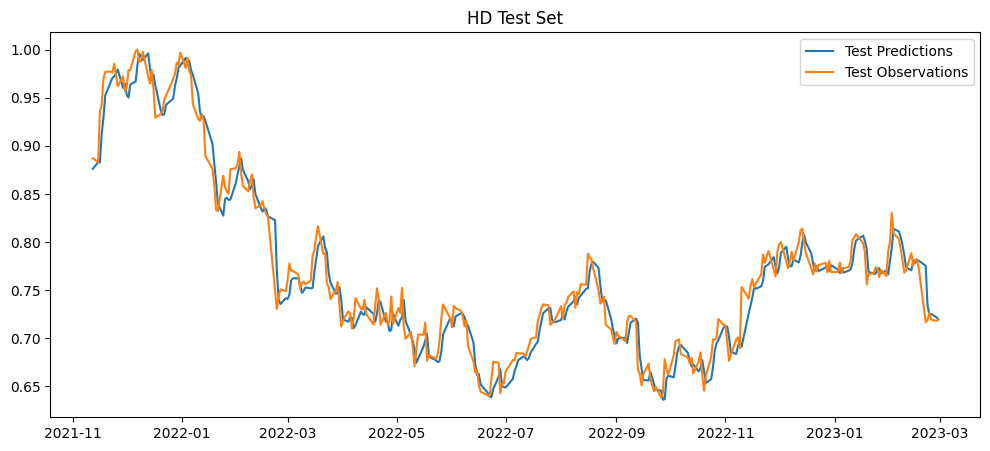

Completed HD (17/20 iterations)


[*********************100%%**********************]  1 of 1 completed


11/11 [==============================] - 0s 907us/step


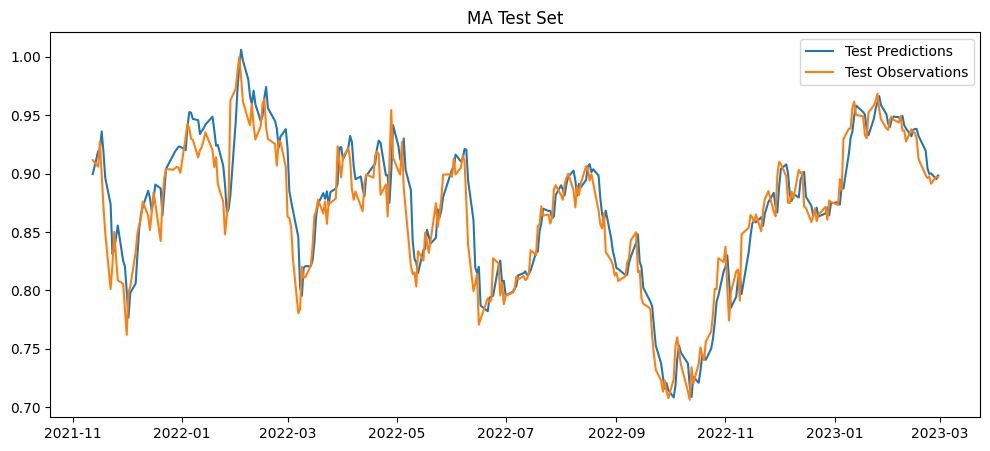

Completed MA (18/20 iterations)


[*********************100%%**********************]  1 of 1 completed


11/11 [==============================] - 0s 900us/step


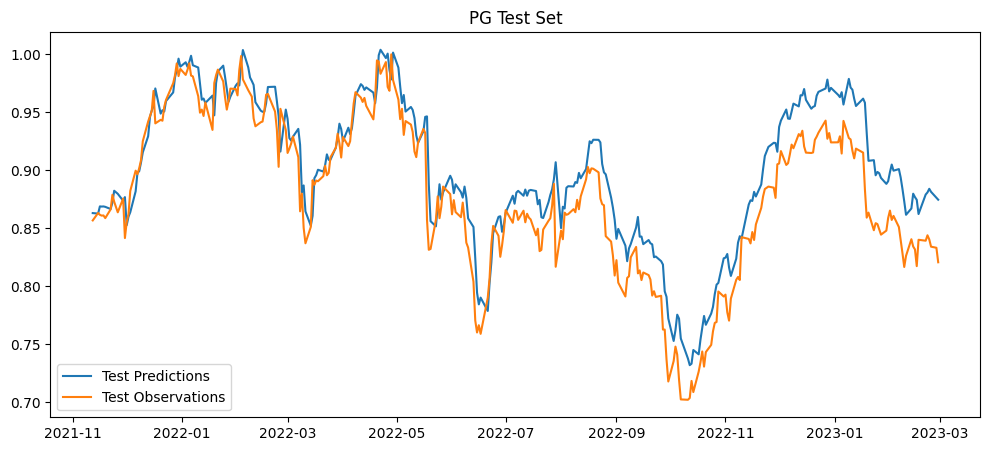

Completed PG (19/20 iterations)


[*********************100%%**********************]  1 of 1 completed


11/11 [==============================] - 0s 914us/step


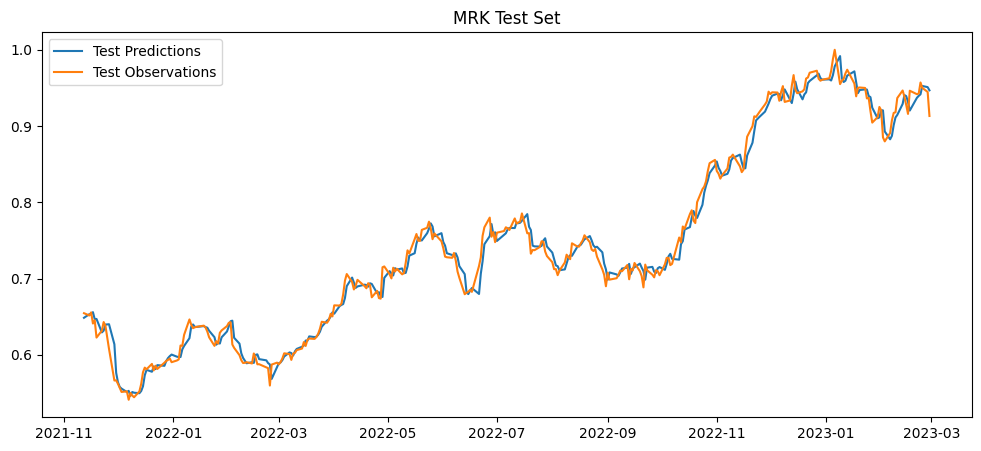

Completed MRK (20/20 iterations)


In [8]:
pred_dict = {}
for i, ticker in enumerate(tqdm(ticker_list['Symbol'], leave=True)):
    pred_dict[ticker] = get_lstm_pred([ticker], macro, start_date, end_date, train_prop, val_prop, look_back, epochs)
    print(f'Completed {ticker} ({i+1}/{len(ticker_list)} iterations)')

##### Cumulative Weighted Returns DataFrame 

In [15]:
ticker_list = ticker_list.set_index(['Symbol'])
ticker_list['Adj Weight']= ticker_list['Weight']/sum(ticker_list['Weight']) # Make stock weights sum to 1
w_long_ret_df = pd.DataFrame() # Weighted Long Return DataFrame
w_strat_ret_df = pd.DataFrame() # Weighted Strategy Return DataFrame

# Create DataFrame of cumulative individual returns weighted by market cap
for i, ticker in enumerate(ticker_list.index):
    w_long_ret_df[f'{i+1}. {ticker} Long WCR'] = pred_dict[ticker]['Long Cum Ret']*ticker_list.loc[ticker]['Adj Weight']
    w_strat_ret_df[f'{i+1}. {ticker} Strat WCR'] = pred_dict[ticker]['Strat Cum Ret']*ticker_list.loc[ticker]['Adj Weight']
# WCR := 'Weighted Cumulative Return'

##### Combintion of Returns into one DataFrame

In [16]:
cum_ret = pd.DataFrame()
cum_ret['Long Returns'] = w_long_ret_df.sum(axis=1) # Blend of the long returns
cum_ret['Strat Returns'] = w_strat_ret_df.sum(axis=1) # Blend of the strategy returns
display(cum_ret)

,Long Returns,Strat Returns
2021-11-12,0.000000,0.000000
2021-11-15,-0.002025,-0.001568
2021-11-16,0.002861,0.000225
2021-11-17,0.000865,-0.001088
2021-11-18,0.017352,0.009554
...,...,...
2023-02-22,-0.121156,-0.028424
2023-02-23,-0.109100,-0.025964
2023-02-24,-0.121989,-0.030685
2023-02-27,-0.117810,-0.030049


##### Portfolio Statistics

In [17]:
rf_mean = np.mean(macro['3 Mo Yield']) # Risk-free rate
print(cum_ret.diff())

            Long Returns  Strat Returns
2021-11-12           NaN            NaN
2021-11-15     -0.002025      -0.001568
2021-11-16      0.004886       0.001793
2021-11-17     -0.001996      -0.001312
2021-11-18      0.016488       0.010642
...                  ...            ...
2023-02-22     -0.000595       0.000878
2023-02-23      0.012056       0.002460
2023-02-24     -0.012889      -0.004721
2023-02-27      0.004180       0.000635
2023-02-28     -0.002771      -0.000738

[322 rows x 2 columns]


In [20]:
print(f'PORTFOLIO STATISTICS OVER THE TEST PERIOD ({cum_ret.index[0]} to {cum_ret.index[-1]}):')
# Returns
daily_ret = cum_ret.diff().iloc[2:]
display(daily_ret)
print('Strategy Return: {:.2f}%'.format((cum_ret['Strat Returns'].iloc[-1]) * 100))
print('Long Return: {:.2f}%'.format((cum_ret['Long Returns'].iloc[-1]) * 100))


# Volatility
port_vol = np.std(daily_ret['Strat Returns']) 
long_vol = np.std(daily_ret['Long Returns'])
print('Strat Volatility: {:.2f}%'.format(port_vol * 100 * np.sqrt(252))) # Annualized Volatility
print('Long Volatility: {:.2f}%'.format(long_vol * 100 * np.sqrt(252))) # Annualized Volatility

# Calculate Daily Risk-Free Rate from APY
r_f = (1 + macro['3 Mo Yield'] / 100)**(1/252) - 1

# Sharpe Ratios
port_sharpe = np.mean(daily_ret['Strat Returns'] - r_f) * np.sqrt(252) / np.std(daily_ret['Strat Returns'])
long_sharpe = np.mean(daily_ret['Long Returns'] - r_f) * np.sqrt(252) / np.std(daily_ret['Long Returns'])
print('Strategy Sharpe Ratio: {:.2f}'.format(port_sharpe))
print('Long Sharpe Ratio: {:.2f}'.format(long_sharpe))


PORTFOLIO STATISTICS OVER THE TEST PERIOD (2021-11-12 00:00:00 to 2023-02-28 00:00:00):


,Long Returns,Strat Returns
2021-11-16,0.004886,0.001793
2021-11-17,-0.001996,-0.001312
2021-11-18,0.016488,0.010642
2021-11-19,0.001688,-0.000010
2021-11-22,-0.009022,-0.009316
...,...,...
2023-02-22,-0.000595,0.000878
2023-02-23,0.012056,0.002460
2023-02-24,-0.012889,-0.004721
2023-02-27,0.004180,0.000635


Strategy Return: -3.08%
Long Return: -12.06%
Strat Volatility: 20.35%
Long Volatility: 26.15%
Strategy Sharpe Ratio: -0.22
Long Sharpe Ratio: -0.44


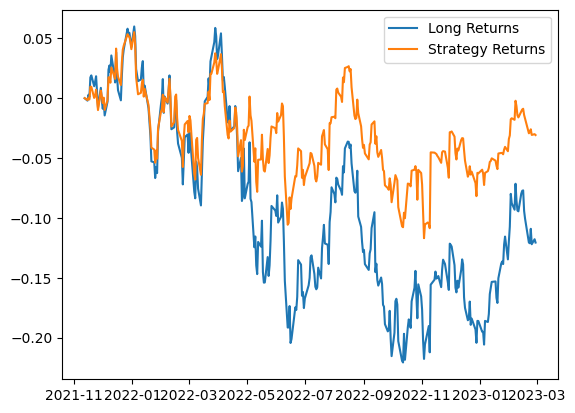

In [19]:
plt.plot(cum_ret.index, cum_ret['Long Returns'])
plt.plot(cum_ret.index, cum_ret['Strat Returns'])
plt.legend(['Long Returns','Strategy Returns'])
plt.show()